# Unsupervised Clustering using VQE

### DataPoint
First, we'll have to create a DataPoint class, that can be used to store and compare input-datapoints. We'll do this as follows, including a ```dist``` function to compute the squared-distance between two datapoints:

In [3]:
# This import is required in python version < 3.11 to allos reference to DataPoint inside definition of DataPoint
from __future__ import annotations


# Helper functions
def sqr(x: float):
    return x * x


class DataPoint:
    x: float
    y: float

    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

    def dist(self, o: DataPoint) -> float:
        return sqr(o.x - self.x) + sqr(o.y - self.y)

Also implement the ```map``` function, that can be used to map Data Points onto the Bloch Sphere:

In [12]:
def map(a: float, b: float, c: float, d: float, e: float) -> float:
    return d + ((a - b)/(c - b)) * (e - d)

### Qiskit
Now, we start working with Qiskit! Import all the necessary elements:

In [64]:
import numpy as np

import matplotlib.pyplot as plt

from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.algorithms.optimizers import SPSA
from qiskit.quantum_info import state_fidelity

from tqdm import tqdm
import math

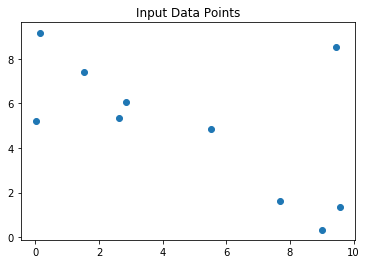

 20%|██        | 2/10 [00:00<00:01,  7.62it/s]

In [ ]:
# Fix the np random seed
np.random.seed(12)

#
# Hard-code the data points that the algorithm will be performed on
#
data_points = [DataPoint(np.random.uniform(low=0, high=10), np.random.uniform(low=0, high=10)) for i in range(10)]

# Plot the datapoints
plt.title("Input Data Points")
plt.scatter(
    [dp.x for dp in data_points],
    [dp.y for dp in data_points]
)
plt.show()

#
# Hard-code the two reference states on the bloch-sphere that we will use as references for two clusters
#
# [1, 0] = |0> and [0, 1] = |1>
reference_points = [[1, 0], [0, 1]]

circuit_counter = 0
# Function: setup the variational form according to given parameters
def setup_variational_form(dp: DataPoint, params) -> QuantumCircuit:
    global circuit_counter
    
    q_circuit = QuantumCircuit(1)
    q_circuit.name = "circuit" + str(circuit_counter)
    circuit_counter += 1
    q_circuit.initialize([1, 0], 0)
    
    q_circuit.u(
        map(dp.x, 0, 10, -math.pi, math.pi),
        map(dp.y, 0, 10, -math.pi, math.pi),
        0,
        0
    )
    q_circuit.u(params[0], params[1], 0, 0)
    
    #print("Quantum Circuit:")
    #print(q_circuit)
    
    q_circuit.save_statevector()
    
    return q_circuit

#setup_variational_form(DataPoint(0, 0), [0, 0])


# Objective function
def objective(params) -> float:
    total_cost = 0
    
    # Select the qiskit backend
    qiskit_backend = Aer.get_backend("aer_simulator")
    
    
    for i in tqdm(range(len(data_points))):
        for j in range(len(data_points)):
            if i != j:
                #print("\tConsidering point [" + str(i) + ", " + str(j) + "]")
                # Compute the fidelity
                job_dp1 = qiskit_backend.run(
                    transpile(
                        setup_variational_form(data_points[i], params),
                        backend=qiskit_backend
                    )
                )
                #job_dp1.wait_for_final_state()

                job_dp2 = qiskit_backend.run(
                    transpile(
                        setup_variational_form(data_points[j], params),
                        backend=qiskit_backend
                    )
                )
                #job_dp2.wait_for_final_state()
                
                # Compute fidelities with reference points
                for r in reference_points:
                    # Add the input-set-distance to the cost
                    cost = data_points[i].dist(data_points[j])
                    cost *= state_fidelity(r, job_dp1.result().get_statevector())
                    cost *= state_fidelity(r, job_dp2.result().get_statevector())
                    total_cost += cost
    
    #print("Total cost: " + str(total_cost))
                    
    return total_cost

# Select the right optimizer
optimizer = SPSA(maxiter=20)

# Initialize the parameters with random values
params_init = np.random.rand(2)

# Perform the optimization and store the result
optimal_params = optimizer.minimize(fun=objective, x0=params_init).x

print(optimal_params)
print("Total cost: " + str(objective(optimal_params)))

